# Advanced Lane Finding #

This project is a part of the Udacity Self-Driving Nanodegree. The specifications to be met are:

1. Writeup
    - Provide a Writeup / README that includes all the rubric points and how addressed each one is addressed.
2. Camera Calibration
    - Briefly state how the camera matrix and distortion coefficients are computed. Provide an example of a distortion corrected calibration image.
3. Pipeline to detect lane lines and find radius of curvature - applied on given test images
    - Provide an example of a distortion-corrected image.
    - Describe how and where in the code - color transforms, gradients or other methods are used to create a thresholded binary image. Provide an example of a binary image result.
    - Describe how and where in the code a perspective transform is performed and provide an example of a transformed image.
    - Describe how and where in the code lane-line pixels are identified and their positions are fitted with a polynomial
    - Describe how and where in the code the radius of curvature of the lane and the position of the vehicle with respect to center are calculated.
    - Provide an example image of the result plotted back down onto the road such that the lane area is identified clearly.
4. Pipeline to detect lane line and find radius of curvature and position - applied on given video 
    - pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!)
5. Provide description of any problems / issues faced in your implementation of this project, possible areas of failure and ideas to make it more robust.

This notebook contains code for camera calibration and also the pipeline for detecting lane lines to calculate radius of curvature and position from both images and videos.

In [1]:
# Required Python libaries to be imported

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import glob
import pickle
from collections import deque
from moviepy.editor import VideoFileClip
from IPython.display import HTML

The images output by a camera are usually distorted. The first step is therefore to calibrate the camera to enable removal of distortion.

## 1. Camera Calibration ##

One of the commonly used procedures to calibrate a camera is to use images of a chessboard, detect its corners and calculate the distortion and camera matrices with the help of 3-D coordinates of the real world chessboard.

In [2]:
calib_imgfiles = glob.glob('./camera_cal/calibration*.jpg')

objpoints = []
imgpoints = []

# Find 3d object points and corresponding 2d image points for each of the calibration images
for calib_imgfile in calib_imgfiles:
    # Read the image file and convert it to grayscale
    calib_img = cv2.imread(calib_imgfile)
    gray_calib = cv2.cvtColor(calib_img, cv2.COLOR_BGR2GRAY)
    # Create object points in 3d space using mgrid
    obj3d = np.zeros((9*6,3), np.float32)
    obj3d[:,:-1] = np.mgrid[0:9, 0:6].T.reshape(-1,2)
    # Detect and capture the chessboard corners from the images
    ret, corners = cv2.findChessboardCorners(gray_calib, (9,6), None)
    if ret==True:
        imgpoints.append(corners)
        objpoints.append(obj3d)
        
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray_calib.shape[::-1], None, None)

# Save the camera matrix and distortion coefficients in a pickle file to avoid recalculation
calib_data = {}
calib_data['mtx'] = mtx
calib_data['dist'] = dist
pickle.dump(calib_data, open('./camera_cal/calib_data.p', 'wb'))

### Undistort camera image ###
We can now undistort the camera images using cv2.undistort feeding in the camera matrix and distortion coefficients, and also test it on one of the chessboard images.

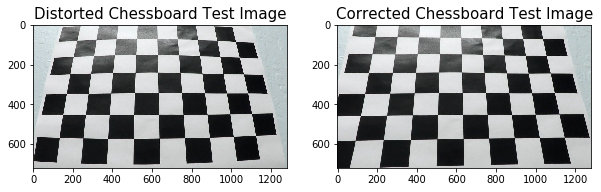

In [3]:
# Load the camera matrix and distortion coefficients from the saved pickle file
pickle_calib_data = pickle.load(open('./camera_cal/calib_data.p', 'rb'))
mtx = pickle_calib_data['mtx']
dist = pickle_calib_data['dist']

# Apply the undistort function on a test chessboard image and display both the input and output images
test_img = cv2.imread('./camera_cal/calibration3.jpg')
corrected_img = cv2.undistort(test_img, mtx, dist, None, mtx)
cv2.imwrite('./camera_cal/undistorted_calibration3.jpg', corrected_img)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,10))
ax1.imshow(test_img)
ax1.set_title('Distorted Chessboard Test Image', fontsize=15)
ax2.imshow(corrected_img)
ax2.set_title('Corrected Chessboard Test Image', fontsize=15)

## 2. Lane Detection Pipeline ##
In the following section of code, we have functions to undistort images, perform thresholding based on gradients and colors, perspective transforms, fitting curves, calculating curvature and position and annotating images. 

As a first step, the image taken by the camera needs to be corrected from distortion and we will a function for that.

### Undistort images ###

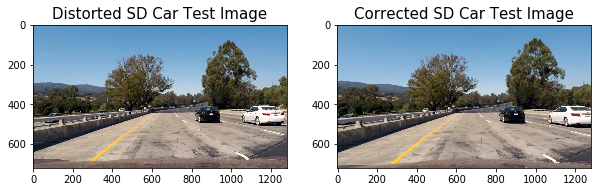

In [4]:
def camera_undistort(image):
    pickle_calib_data = pickle.load(open('./camera_cal/calib_data.p', 'rb'))
    mtx = pickle_calib_data['mtx']
    dist = pickle_calib_data['dist']
    undist_img = cv2.undistort(image, mtx, dist, None, mtx)
    return undist_img

# Here is a sample picture from the test_images folder on which the undistort has been performed
test_sdc_img = mpimg.imread('./test_images/test1.jpg')
undist_sdc_img = camera_undistort(test_sdc_img)
bgr_undist_sdc_img = cv2.cvtColor(undist_sdc_img, cv2.COLOR_RGB2BGR)
cv2.imwrite('./output_images/undistort_test1.jpg', bgr_undist_sdc_img)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,10))
ax1.imshow(test_sdc_img)
ax1.set_title('Distorted SD Car Test Image', fontsize=15)
ax2.imshow(undist_sdc_img)
ax2.set_title('Corrected SD Car Test Image', fontsize=15)


### Thresholding - gradients and colour spaces ###
The lane lines are detected by transforming the images to different colourspaces and thresholding them based on gradients and colour space parameters.

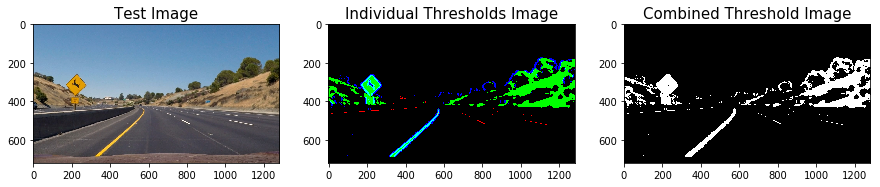

In [83]:
def combined_thresh(image, returnbinary=True):
        
    # The l channel from hls colour space is used to detect the white lane lines
    # A dynamic background based thresholding is performed on 4 regions in the image to capture lane pixels 
    # This means the threshold parameters are dependent on the distribution and composition of the pixels in the image
    hls_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS) 
    hls_ldyn_binary = extract_hls(hls_image, 'l', None, 255) 
    
    #The b channel from lab colour space is used to detect the yellow lane lines
    # This was found to be better than s channel from hls which falsely identified the shadow region on the road as lane pixels
    # The threshold parameters are obtained by trial and error, by trying them out on the main project video and the first challenge video.
    lab_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB) 
    lab_b_binary = extract_lab(lab_image, 'b', 150, 255)
    
    # lab-b-channel colour based thresholding is not sufficient to capture the entire yellow lane line, especially in regions far away from the vehicle
    # So, to supplement it, gradient thresholding is also used. The x-gradients of the b channel in lab colour space are used here.
    labbx_binary = extract_sxy(lab_image[:,:,2], 'x', 2, 10, 255)

    # To visualize the contribution of each of these thresholding approaches, they are combined in one image
    separate_3channel = np.dstack((hls_ldyn_binary , lab_b_binary , labbx_binary))*255
        
    # All 3 of the above mentioned thresholding approaches are combined to detect the lane lines on the road in this project
    combined_binary = np.zeros_like(hls_ldyn_binary)
    combined_binary[(hls_ldyn_binary==1) | (lab_b_binary==1) | (labbx_binary==1)] = 1
    
    # Return binary image for normal pipeline
    # Else return image with 3 separate channels for easy visualization of thresholded areas during checks/tests
    if returnbinary:
        return combined_binary
    else:
        
        return separate_3channel

# Function to get a gradient (either x or y) thresholded binary image
# The gradient threshold is scaled based on the levels in the channel in the region of interest
def extract_sxy(onechannel_image, xy, basefactor, threshmin, threshmax):
    smooth_image = cv2.GaussianBlur(onechannel_image, (7,7), 0)
    if xy == 'x':
        sobelxy = cv2.Sobel(smooth_image, cv2.CV_64F, 1, 0)
    elif xy == 'y':
        sobelxy = cv2.Sobel(smooth_image, cv2.CV_64F, 0, 1)
    else:
        return None
    abs_sobelxy = np.absolute(sobelxy)
    scaled_sobelxy = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    sxy_binary = np.zeros_like(scaled_sobelxy)
    scaledtmin = get_scaled_thresholds_grad(scaled_sobelxy, basefactor, threshmin)
    sxy_binary[(scaled_sobelxy > scaledtmin) & (scaled_sobelxy < threshmax)] = 1
    return sxy_binary

# Function to get a colour thresholded binary image from lab colour space
def extract_lab(lab_image, channel, threshmin, threshmax):
    channel_list = ['l', 'a', 'b']
    selected_channel =  lab_image[:,:,channel_list.index(channel)]
    lab_binary = np.zeros_like(selected_channel)
    lab_binary[(selected_channel > threshmin) & (selected_channel < threshmax)] = 1
    return lab_binary

# Function to get a colour thresholded binary image from hls colour space
# The l space is thresholded dynamically based on the pixel composition and therefore doesnt require a min threshold
def extract_hls(hls_image, channel, threshmin, threshmax):
    channel_list = ['h', 'l', 's']
    selected_channel = hls_image[:,:,channel_list.index(channel)]
    hls_binary = np.zeros_like(selected_channel)
    if channel == 'l':
        if threshmin == None:
            tmin_matrix = get_scaled_thresholds_l(selected_channel, threshmin)
            hls_binary[(selected_channel > tmin_matrix) & (selected_channel < threshmax)] = 1
        else:
            hls_binary[(selected_channel > threshmin) & (selected_channel < threshmax)] = 1
    elif channel == 's':
        hls_binary[(selected_channel > 100) & (selected_channel < threshmax)] = 1
    return hls_binary

# Function to get thresholds for hls-l channel based on the pixel composition
# The composition of the pixels is obtained from histograms of 4 smaller local regions in the image
# The mode of the histograms is used as a reference to choose the threshold value for the l channel
# The thresholds are obtained used trial and error based on images from the main project video and first challenge video
def get_scaled_thresholds_l(channel_image, threshmin):
    # by default, use 200 as threshold value
    tmin_matrix = np.ones_like(channel_image)*200  
    
    mask_box1 = np.zeros(channel_image.shape, np.uint8)
    box1_left, box1_right = 400, 640
    box1_top, box1_bottom = 400, 550
    mask_box1[box1_top:box1_bottom, box1_left:box1_right] = 255
    hist_box1 = cv2.calcHist([channel_image],[0],mask_box1,[256],[0,256])
    #Use special threshold values depending on the 'l' levels of the road pixels
    if np.argmax(hist_box1)>10 and np.argmax(hist_box1)<=20: 
        tmin_matrix[box1_top:box1_bottom, box1_left:box1_right] = 60
    elif np.argmax(hist_box1)>20 and np.argmax(hist_box1)<=100:
        tmin_matrix[box1_top:box1_bottom, box1_left:box1_right] = 180
    elif np.argmax(hist_box1)>100 and np.argmax(hist_box1)<=150:
        tmin_matrix[box1_top:box1_bottom, box1_left:box1_right] = 165
    elif np.argmax(hist_box1)>150 and np.argmax(hist_box1)<=200:
        tmin_matrix[box1_top:box1_bottom, box1_left:box1_right] = np.argmax(hist_box1)*1.15
    # 5% of the pixels in this box occupies a huge portion on warped image, indicating that thresholding is unsuccessful
    # In this case, use standard 200 value instead
    hot_pixels = (channel_image[box1_top:box1_bottom, box1_left:box1_right]>tmin_matrix[box1_top:box1_bottom, box1_left:box1_right])
    if np.sum(hot_pixels) > 0.05*((box1_bottom-box1_top)*(box1_right-box1_left)):
        tmin_matrix[box1_top:box1_bottom, box1_left:box1_right] = 200
    # If more than 5% of pixels in this box are hot, even after standard 200 values, then discard and use 500, a very high value
    hot_pixels = (channel_image[box1_top:box1_bottom, box1_left:box1_right]>tmin_matrix[box1_top:box1_bottom, box1_left:box1_right])
    if np.sum(hot_pixels) > 0.05*((box1_bottom-box1_top)*(box1_right-box1_left)):
        tmin_matrix[box1_top:box1_bottom, box1_left:box1_right] = 500

    mask_box2 = np.zeros(channel_image.shape, np.uint8)
    box2_left, box2_right = 640, 880
    box2_top, box2_bottom = 400, 550
    mask_box2[box2_top:box2_bottom, box2_left:box2_right] = 255
    hist_box2 = cv2.calcHist([channel_image],[0],mask_box2,[256],[0,256])
    #Use special threshold values depending on the 'l' levels of the road pixels
    if np.argmax(hist_box2)>10 and np.argmax(hist_box2)<=20: 
        tmin_matrix[box2_top:box2_bottom, box2_left:box2_right] = 60
    elif np.argmax(hist_box2)>20 and np.argmax(hist_box2)<=100:
        tmin_matrix[box2_top:box2_bottom, box2_left:box2_right] = 180
    elif np.argmax(hist_box2)>100 and np.argmax(hist_box2)<=150:
        tmin_matrix[box2_top:box2_bottom, box2_left:box2_right] = 165
    elif np.argmax(hist_box2)>150 and np.argmax(hist_box2)<=200:
        tmin_matrix[box2_top:box2_bottom, box2_left:box2_right] = np.argmax(hist_box2)*1.15
    # 5% of the pixels in this box occupies a huge portion on warped image, indicating that thresholding is unsuccessful
    # In this case, use standard 200 value instead
    hot_pixels = (channel_image[box2_top:box2_bottom, box2_left:box2_right]>tmin_matrix[box2_top:box2_bottom, box2_left:box2_right])
    if np.sum(hot_pixels) > 0.05*((box2_bottom-box2_top)*(box2_right-box2_left)):
        tmin_matrix[box2_top:box2_bottom, box2_left:box2_right] = 200
    # If more than 5% of pixels in this box are hot, even after standard 200 values, then discard and use 500, a very high value
    hot_pixels = (channel_image[box2_top:box2_bottom, box2_left:box2_right]>tmin_matrix[box2_top:box2_bottom, box2_left:box2_right])
    if np.sum(hot_pixels) > 0.05*((box2_bottom-box2_top)*(box2_right-box2_left)):
        tmin_matrix[box2_top:box2_bottom, box2_left:box2_right] = 500

    mask_box3 = np.zeros(channel_image.shape, np.uint8)
    box3_left, box3_right = 200, 640
    box3_top, box3_bottom = 550, 700
    mask_box3[box3_top:box3_bottom, box3_left:box3_right] = 255
    hist_box3 = cv2.calcHist([channel_image],[0],mask_box3,[256],[0,256])
    #Use special threshold values depending on the 'l' levels of the road pixels
    if np.argmax(hist_box3)>10 and np.argmax(hist_box3)<=20: 
        tmin_matrix[box3_top:box3_bottom, box3_left:box3_right] = 60
    elif np.argmax(hist_box3)>20 and np.argmax(hist_box3)<=100:
        tmin_matrix[box3_top:box3_bottom, box3_left:box3_right] = 180
    elif np.argmax(hist_box3)>100 and np.argmax(hist_box3)<=150:
        tmin_matrix[box3_top:box3_bottom, box3_left:box3_right] = 165
    elif np.argmax(hist_box3)>150 and np.argmax(hist_box3)<=200:
        tmin_matrix[box3_top:box3_bottom, box3_left:box3_right] = np.argmax(hist_box3)*1.15
    # 10% of the pixels in this box occupies a huge portion on warped image, indicating that thresholding is unsuccessful
    # In this case, use standard 200 value instead
    hot_pixels = (channel_image[box3_top:box3_bottom, box3_left:box3_right]>tmin_matrix[box3_top:box3_bottom, box3_left:box3_right])
    if np.sum(hot_pixels) > 0.1*((box3_bottom-box3_top)*(box3_right-box3_left)):
        tmin_matrix[box3_top:box3_bottom, box3_left:box3_right] = 200
    # If more than 10% of pixels in this box are hot, even after standard 200 values, then discard and use 500, a very high value
    hot_pixels = (channel_image[box3_top:box3_bottom, box3_left:box3_right]>tmin_matrix[box3_top:box3_bottom, box3_left:box3_right])
    if np.sum(hot_pixels) > 0.1*((box3_bottom-box3_top)*(box3_right-box3_left)):
        tmin_matrix[box3_top:box3_bottom, box3_left:box3_right] = 500

    mask_box4 = np.zeros(channel_image.shape, np.uint8)
    box4_left, box4_right = 640, 1080
    box4_top, box4_bottom = 550, 700
    mask_box4[box4_top:box4_bottom, box4_left:box4_right] = 200
    hist_box4 = cv2.calcHist([channel_image],[0],mask_box4,[256],[0,256])
    #Use special threshold values depending on the 'l' levels of the road pixels
    if np.argmax(hist_box4)>10 and np.argmax(hist_box4)<=20: 
        tmin_matrix[box4_top:box4_bottom, box4_left:box4_right] = 60
    elif np.argmax(hist_box4)>20 and np.argmax(hist_box4)<=100:
        tmin_matrix[box4_top:box4_bottom, box4_left:box4_right] = 180
    elif np.argmax(hist_box4)>100 and np.argmax(hist_box4)<=150:
        tmin_matrix[box4_top:box4_bottom, box4_left:box4_right] = 165
    elif np.argmax(hist_box4)>150 and np.argmax(hist_box4)<=200:
        tmin_matrix[box4_top:box4_bottom, box4_left:box4_right] = np.argmax(hist_box4)*1.15
    # 10% of the pixels in this box occupies a huge portion on warped image, indicating that thresholding is unsuccessful
    # In this case, use standard 200 value instead
    hot_pixels = (channel_image[box4_top:box4_bottom, box4_left:box4_right]>tmin_matrix[box4_top:box4_bottom, box4_left:box4_right])
    if np.sum(hot_pixels) > 0.1*((box4_bottom-box4_top)*(box4_right-box4_left)):
        tmin_matrix[box4_top:box4_bottom, box4_left:box4_right] = 200
    # If more than 10% of pixels in this box are hot, even after standard 200 values, then discard and use 500, a very high value
    hot_pixels = (channel_image[box4_top:box4_bottom, box4_left:box4_right]>tmin_matrix[box4_top:box4_bottom, box4_left:box4_right])
    if np.sum(hot_pixels) > 0.1*((box4_bottom-box4_top)*(box4_right-box4_left)):
        tmin_matrix[box4_top:box4_bottom, box4_left:box4_right] = 500
    
    return tmin_matrix
    
   
def get_scaled_thresholds_grad(channel_image, basefactor, threshmin):
    roi_xmin = int(channel_image.shape[1]*0.15)
    roi_xmax = int(channel_image.shape[1]*0.85)
    roi_ymin = int(channel_image.shape[0]*0.5)
    roi_ymax = int(channel_image.shape[0]*0.9)
    channel_avg_roi = np.mean(channel_image[roi_ymin:roi_ymax, roi_xmin:roi_xmax])
    return (channel_avg_roi/basefactor)*threshmin
    
# Thresholding on a sample test image
test_sdc_img = mpimg.imread('./test_images/test2.jpg')
multi_thresh_img = combined_thresh(test_sdc_img, False)
bgr_multi_thresh_img = cv2.cvtColor(multi_thresh_img, cv2.COLOR_RGB2BGR)
cv2.imwrite('./output_images/multi_thresh_example.jpg', bgr_multi_thresh_img)
combined_thresh_img = combined_thresh(test_sdc_img)
bgr_combined_thresh_img = np.dstack((combined_thresh_img, combined_thresh_img, combined_thresh_img))*255
cv2.imwrite('./output_images/combined_thresh_example.jpg', bgr_combined_thresh_img)
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,15))
ax1.imshow(test_sdc_img)
ax1.set_title('Test Image', fontsize=15)
ax2.imshow(multi_thresh_img)
ax2.set_title('Individual Thresholds Image', fontsize=15)
ax3.imshow(combined_thresh_img, cmap='gray')
ax3.set_title('Combined Threshold Image', fontsize=15)

### Warp to Bird's Eye View ###
The images with the detected lane lines need to be warped using perspective transform to get a bird's eyeview, so that the lane lines are parallel and equidistant. This helps in calculating the position and radius of curvature properly.

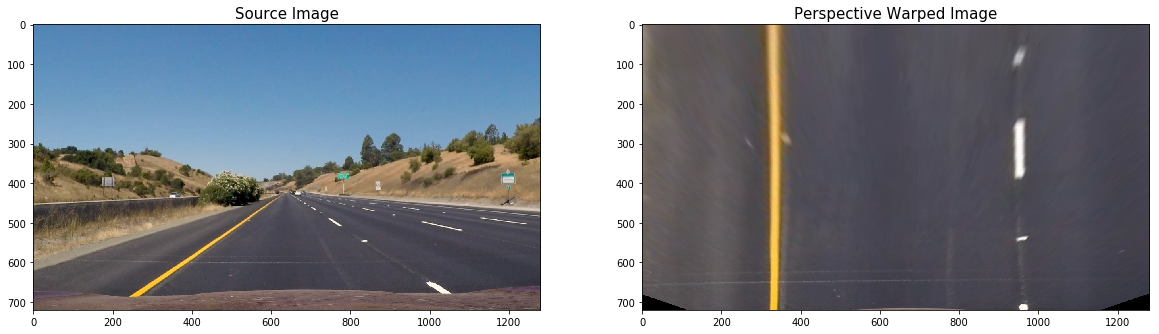

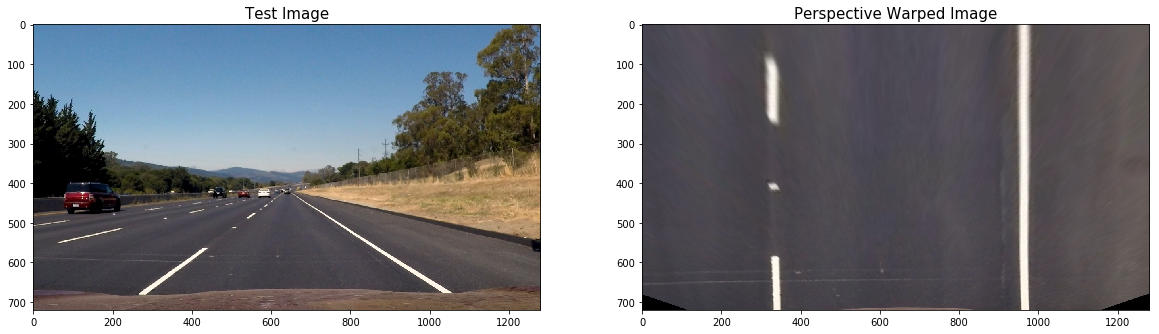

In [30]:
# Find tranformation matrices M and Minv with the help of straight lane line images 
src_img = mpimg.imread('./test_images/straight_lines1.jpg')

src = np.float32([[565, 470], [720, 470], [1040, 680], [250, 680]]) # - values taken from source image

dst = np.float32([[int(0.25*src_img.shape[1]), 0], [int(0.75*src_img.shape[1]), 0], 
       [int(0.75*src_img.shape[1]), src_img.shape[0]], [int(0.25*src_img.shape[1]), src_img.shape[0]]])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
warp_persp_data = {'M': M, 'Minv':Minv}
pickle.dump(warp_persp_data, open('./camera_cal/warp_persp_data.p', 'wb'))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,20))
ax1.imshow(src_img)
ax1.set_title('Source Image', fontsize=15)

def warp_birdseyeview(image):
    pickle_warp_persp_data = pickle.load(open('./camera_cal/warp_persp_data.p', 'rb'))
    M = pickle_warp_persp_data['M']
    dst_image = cv2.warpPerspective(image, M, image.shape[1::-1], flags=cv2.INTER_LINEAR) 
    return dst_image

dst_img = warp_birdseyeview(camera_undistort(src_img))
ax2.imshow(dst_img)
ax2.set_title('Perspective Warped Image', fontsize=15)

# Example transform on test image
test_img = mpimg.imread('./test_images/straight_lines2.jpg')
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,20))
ax1.imshow(test_img)
ax1.set_title('Test Image', fontsize=15)
res_img = warp_birdseyeview(camera_undistort(test_img))
output_img = cv2.cvtColor(res_img, cv2.COLOR_RGB2BGR)
cv2.imwrite('./output_images/warp_straight_lines2.jpg', output_img)
ax2.imshow(res_img)
ax2.set_title('Perspective Warped Image', fontsize=15)

### Detect Lane Line Pixels and Fit Curves ###
The pixels belonging only to the left and right lane lines need to be separated from the other elements in the image inorder to fit curves for the lane lines. The parameters of this fitted curve can be used to calculate the radius of curvature of the road.

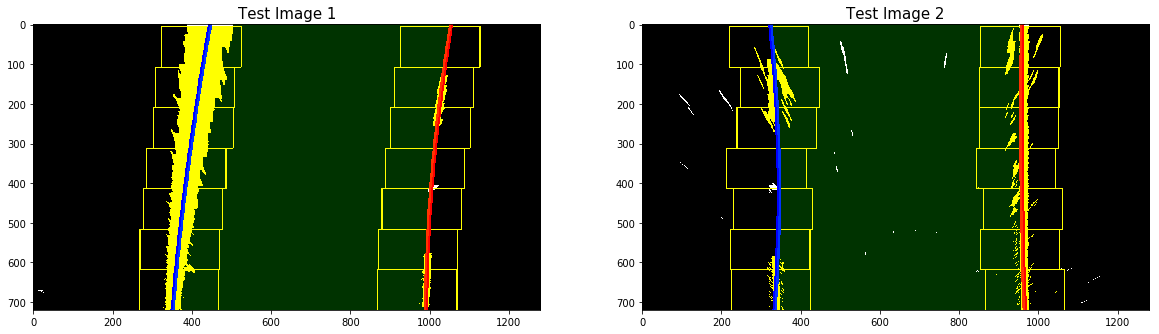

In [90]:
# A tracker is required to track the progress of the lane lines from frame to frame
class lane_lines_tracker:
    def __init__(self):
        # Deque is maintained for a reference to debug and check
        # EMA calculation is done at every step and doesn't require deque at all
        self.left_coeffs_hist = deque(maxlen=10) 
        self.right_coeffs_hist = deque(maxlen=10)
        self.counter = 0
        self.current_smoothed_left_coeffs = np.zeros(3)
        self.current_smoothed_right_coeffs = np.zeros(3)
        self.current_left_coeffs = np.zeros(3)
        self.current_right_coeffs = np.zeros(3)
        self.lane_width = 0
        self.window_mode = True
        self.blackout_state = True
        
    def add_to_history(self, left_coeffs, right_coeffs):
        #self.left_coeffs_hist.append(left_coeffs)
        #self.right_coeffs_hist.append(right_coeffs)
        self.current_left_coeffs = left_coeffs
        self.current_right_coeffs = right_coeffs
        self.lane_width = ((self.lane_width*self.counter)+(right_coeffs[2]-left_coeffs[2]))/(self.counter+1)
    
    def update_frame_counter(self):
        self.counter = self.counter + 1
        
    def get_current_coeffs(self, imshape):
        if self.counter==0:
            return np.array([0,0,0.25*imshape[1]], np.int32), np.array([0,0,0.75*imshape[1]], np.int32)
        else:
            return self.current_left_coeffs, self.current_right_coeffs
    
    def fit_curves_to_pixels(self, x, y):
        #Fitting the coefficients of the 2nd order polynomial to the identified pixels
        coeffs = np.polyfit(y, x, 2)
        return coeffs
    
    def update_expsmooth_coeff(self, factor):
        if self.counter <= 1:
            self.current_smoothed_left_coeffs = self.current_left_coeffs
            self.current_smoothed_right_coeffs = self.current_right_coeffs
        else:
            self.current_smoothed_left_coeffs = ((1-factor)*self.current_smoothed_left_coeffs) + (factor*(self.current_left_coeffs))
            self.current_smoothed_right_coeffs = ((1-factor)*self.current_smoothed_right_coeffs) + (factor*(self.current_right_coeffs))
        return self.current_smoothed_left_coeffs, self.current_smoothed_right_coeffs
    
    def predict_left_from_history(self, imshape):
        self.current_smoothed_left_coeffs, b = self.predict_from_history(imshape)
        return self.current_smoothed_left_coeffs
    
    def predict_right_from_history(self, imshape):
        a, self.current_smoothed_right_coeffs = self.predict_from_history(imshape)
        return self.current_smoothed_right_coeffs
    
    def predict_from_history(self, imshape):
        # Return coeffs for two straight lines at x=0.25*width and x=0.75*width when no history available
        if self.counter == 0:
            return np.array([0,0,0.25*imshape[1]], np.int32), np.array([0,0,0.75*imshape[1]], np.int32)
        else:
        # Return the current smoothed coefficients, since it is the simplest estimate based on history
            return self.current_smoothed_left_coeffs, self.current_smoothed_right_coeffs
    
    def get_window_mode(self):
        return self.window_mode

    def set_window_mode_off(self):
        self.window_mode = False
        
    def set_window_mode_on(self):
        self.window_mode = True
  
    def set_blackout_off(self):
        self.blackout_state = False
        
    def set_blackout_on(self):
        self.blackout_state = True
        
    def reset(self):
        # The reset can also be done by creating the instance once again, but is added for completeness
        self.left_coeffs_hist.clear()
        self.right_coeffs_hist.clear()
        self.counter = 0
        self.window_mode = True
        self.blackout_state = True
        self.current_smoothed_left_coeffs = np.zeros(3)
        self.current_smoothed_right_coeffs = np.zeros(3)
        self.current_left_coeffs = np.zeros(3)
        self.current_right_coeffs = np.zeros(3)
    
# Function to identify the pixels belonging to the lane lines and return them
def fit_lane_pixels(image, ltracker, returndebug=False):
    # Takes in a binary image, but always returns a 3channel image that can be directly used by plot_lanes function
    colour_image = np.dstack((image, image, image))*255
    imshape = image.shape
    blackout_l_counter = 0
    blackout_r_counter = 0
    # Check if the sliding windows algorithm is to be used, if not use margins around the existing curves
    if ltracker.get_window_mode():
        left_x, left_y, right_x, right_y, left_lane_confidence, right_lane_confidence, colour_image = get_pixels_sliding_window(image, colour_image, ltracker)
    else:
        left_coeffs, right_coeffs = ltracker.get_current_coeffs(imshape)
        left_x, left_y, right_x, right_y, detection_level, colour_image = get_pixels_around_curve(image, colour_image, ltracker, left_coeffs, right_coeffs)
        # Check the extent of detection done with this method using margins around the curves
        # If poor detection level, use method of sliding windows
        if detection_level<0.75:
            ltracker.set_window_mode_on()
            left_x, left_y, right_x, right_y, left_lane_confidence, right_lane_confidence, colour_image = get_pixels_sliding_window(image, colour_image, ltracker)
        else:
            left_lane_confidence = True
            right_lane_confidence = True
    # Call the tracker function to fit 2n deg curves to these pixels, if the confidence levels are greater than a threshold
    # Else predict the coeffs from past data
    # If no past data availabe, use default values of straight line
    # This will prevent empty arrays being fitted and causing errors
    if left_lane_confidence and right_lane_confidence:
        left_coeffs = ltracker.fit_curves_to_pixels(left_x, left_y)
        if not ltracker.blackout_state and np.any(np.absolute(left_coeffs - ltracker.get_current_coeffs(imshape)[0])>np.array([0.0005,0.5,50])):
            left_coeffs = ltracker.get_current_coeffs(imshape)[0]
            blackout_l_counter = blackout_l_counter + 1
        right_coeffs = ltracker.fit_curves_to_pixels(right_x, right_y)
        if not ltracker.blackout_state and np.any(np.absolute(right_coeffs - ltracker.get_current_coeffs(imshape)[1])>np.array([0.0005,0.5,50])):
            right_coeffs = ltracker.get_current_coeffs(imshape)[1]
            blackout_r_counter = blackout_r_counter + 1 
        if blackout_l_counter>3 or blackout_r_counter>3:
            ltracker.set_blackout_on()
            blackout_l_counter = 0
            blackout_r_counter = 0
        elif blackout_l_counter==0 and blackout_r_counter==0:
            ltracker.set_window_mode_off()
    elif not left_lane_confidence and right_lane_confidence:
        right_coeffs = ltracker.fit_curves_to_pixels(right_x, right_y)
        if not ltracker.blackout_state and np.any(np.absolute(right_coeffs - ltracker.get_current_coeffs(imshape)[1])>np.array([0.0003,0.5,50])):
            right_coeffs = ltracker.get_current_coeffs(imshape)[1]
            blackout_r_counter = blackout_r_counter + 1
        left_coeffs = ltracker.predict_left_from_history(imshape)
        if blackout_r_counter>3:
            ltracker.set_blackout_on()
            blackout_l_counter = 0
            blackout_r_counter = 0
        ltracker.set_window_mode_on()
    elif not right_lane_confidence and left_lane_confidence:
        left_coeffs = ltracker.fit_curves_to_pixels(left_x, left_y)
        if not ltracker.blackout_state and np.any(np.absolute(left_coeffs - ltracker.get_current_coeffs(imshape)[0])>np.array([0.0003,0.5,50])):
            left_coeffs = ltracker.get_current_coeffs(imshape)[0]
            blackout_l_counter = blackout_l_counter + 1
        right_coeffs = ltracker.predict_right_from_history(imshape)
        if blackout_l_counter>3:
            ltracker.set_blackout_on()
            blackout_l_counter = 0
            blackout_r_counter = 0
        ltracker.set_window_mode_on()
    else:
        left_coeffs, right_coeffs = ltracker.predict_from_history(imshape)
        ltracker.set_window_mode_on()
    # Add these coefficients to the tracker to maintain a history 
    ltracker.add_to_history(left_coeffs, right_coeffs)
    # Update and get the new exponentially smoothed coefficients for removing sharp fluctuations
    # A factor of 0.75 is used for the ema
    left_smoothed_coeffs, right_smoothed_coeffs = ltracker.update_expsmooth_coeff(0.75)
       # Update the frame counter to keep track of number of frames
    # Return the smoothed coefficients for plotting and calculating curvature and position
    ltracker.update_frame_counter()
    if returndebug == True:
        if left_x!=None:
            colour_image[left_y, left_x, :] = [255, 255, 0]
        if right_x!=None:
            colour_image[right_y, right_x, :] = [255, 255, 0]
        return colour_image, left_smoothed_coeffs, right_smoothed_coeffs
    else:
        multichannel_blank_image = np.zeros_like(colour_image)
        return multichannel_blank_image, left_smoothed_coeffs, right_smoothed_coeffs

def get_pixels_sliding_window(image, colour_image, ltracker):
    template_width = 70
    template = np.ones(template_width)
    lane_width = image.shape[1]//2 # must be an integer for easy addition to pixel numbers
    no_of_window_layers = 7
    winh = image.shape[0]//7
    winw = 200
    win_threshmin = 300
    left_lane_pixels = []
    right_lane_pixels = []
    nonzeroy, nonzerox = image.nonzero()
    leftwin_captured = 0
    rightwin_captured = 0
    bottomleft_captured = 0
    topleft_captured = 0
    bottomright_captured = 0
    topright_captured = 0
    left_lane_confidence = False
    right_lane_confidence = False
    for window_layer in range(no_of_window_layers):
        winno = window_layer+1
        by = image.shape[0]-((window_layer)*winh)
        ty = image.shape[0]-(winno*winh)
        if winno == 1:
            # Default start points in case no pixels are available
            sw_cx_left = int(0.25*image.shape[1])
            sw_cx_right = int(0.75*image.shape[1])
            # take start points by finding out the max position of the sum of the 'on' pixels along y axis
            lefthalfsum = np.sum(image[image.shape[0]//2:, :image.shape[1]//2], axis=0)
            righthalfsum = np.sum(image[image.shape[0]//2:, image.shape[1]//2:], axis=0)
            sw_cx_left = max(np.argmax(lefthalfsum), winw//2)
            sw_cx_right = min(image.shape[1]//2 + np.argmax(righthalfsum), image.shape[1]-winw//2)
        else:
            # take starting point from previous window layer
            sw_cx_left = sw_cx_left - sliding_dist_left
            sw_cx_right = sw_cx_right - sliding_dist_right
        # take a window with above start points and start convolving with a standard template of 70 pixels    
        lx_left = sw_cx_left-winw//2 
        rx_left = sw_cx_left+winw//2  
        lx_right = sw_cx_right-winw//2 
        rx_right = sw_cx_right+winw//2
        # Convolving left window, catching exception in case only zero pixels are found
        imgwindow_left = np.sum(image[ty:by, lx_left:rx_left], axis=0)
        try:
            conv_left = np.convolve(template, imgwindow_left)
            # Measure confidence levels for the left window
            leftwin_confidence = np.max(conv_left)
        except:
            leftwin_confidence = 0
        # Convolving right window, catching exception in case only zero pixels are found
        imgwindow_right = np.sum(image[ty:by, lx_right:rx_right], axis=0)
        try:
            conv_right = np.convolve(template, imgwindow_right)
            # Measure confidence levels for the right window
            rightwin_confidence = np.max(conv_right)
        except:
            rightwin_confidence = 0 
        # Decide and update sliding distance based on confidence levels in detecting pixels
        is_leftwin_correct = leftwin_confidence>win_threshmin
        is_rightwin_correct = rightwin_confidence>win_threshmin
        if is_leftwin_correct and is_rightwin_correct:
            sliding_dist_left = winw//2 + template_width//2 - np.argmax(conv_left)
            sliding_dist_right = winw//2 + template_width//2 - np.argmax(conv_right)
        # Borrow sliding distance from the other lane in case one lane doesn't detect pixels
        elif is_rightwin_correct and not is_leftwin_correct:
            sliding_dist_right = winw//2 + template_width//2 - np.argmax(conv_right)
            sliding_dist_left = sliding_dist_right
        elif is_leftwin_correct and not is_rightwin_correct:
            sliding_dist_left = winw//2 + template_width//2 - np.argmax(conv_left)
            sliding_dist_right = sliding_dist_left
        # Give zero sliding in case both lanes dont detect pixels
        else:
            sliding_dist_left = 0
            sliding_dist_right = 0
        # Get coordinates of the rectangle based on the new sliding window position
        upd_lx_left = lx_left - sliding_dist_left
        upd_rx_left = rx_left - sliding_dist_left
        upd_lx_right = lx_right - sliding_dist_right
        upd_rx_right = rx_right - sliding_dist_right  
        win_cenx_left = upd_lx_left + winw//2
        win_cenx_right = upd_lx_right + winw//2
        cv2.rectangle(colour_image, (upd_lx_left, by), (upd_rx_left, ty), (255, 255, 0), 2)
        cv2.rectangle(colour_image, (upd_lx_right, by), (upd_rx_right, ty), (255, 255, 0), 2)
        # Append all the pixels in the rectangles to their corresponding lane lists, if confident
        # Add 1 for each window confidence to total confidence level for detection of each lane
        if is_leftwin_correct:
            left_lane_pixels.append(np.where((nonzerox>upd_lx_left)&(nonzerox<upd_rx_left)&(nonzeroy>ty)&(nonzeroy<by))[0])
            leftwin_captured = leftwin_captured + 1
            if winno<=no_of_window_layers//2:
                bottomleft_captured = bottomleft_captured + 1
            if winno>(no_of_window_layers//2)+1:
                topleft_captured = topleft_captured + 1
        if is_rightwin_correct:
            right_lane_pixels.append(np.where((nonzerox>upd_lx_right)&(nonzerox<upd_rx_right)&(nonzeroy>ty)&(nonzeroy<by))[0])
            rightwin_captured = rightwin_captured + 1
            if winno<=no_of_window_layers//2:
                bottomright_captured = bottomright_captured + 1
            if winno>(no_of_window_layers//2)+1:
                topright_captured = topright_captured + 1
        if leftwin_captured>2 and bottomleft_captured>0 and topleft_captured>0:
            left_lane_confidence = True
        if rightwin_captured>2 and bottomright_captured>0 and topright_captured>0:
            right_lane_confidence = True    
        
    # Once all the windows are identified, concatenate all the pixels together
    if left_lane_confidence:
        left_lane_pixels = np.concatenate(left_lane_pixels)
        left_x = nonzerox[left_lane_pixels]
        left_y = nonzeroy[left_lane_pixels]
    else: 
        left_x = None
        left_y = None
    if right_lane_confidence:
        right_lane_pixels = np.concatenate(right_lane_pixels)
        right_x = nonzerox[right_lane_pixels]
        right_y = nonzeroy[right_lane_pixels]
    else:
        right_x = None
        right_y = None
    return left_x, left_y, right_x, right_y, left_lane_confidence, right_lane_confidence, colour_image


def get_pixels_around_curve(image, colour_image, ltracker, left_coeffs, right_coeffs):
    nonzeroy, nonzerox = image.nonzero()
    margin = 100
    #For given nonzeroy pixel , find the min and max limits of x within which to search for lane pixels
    leftlane_xmin = ((left_coeffs[0]*(nonzeroy**2)) + (left_coeffs[1]*nonzeroy) + left_coeffs[2]) - margin
    leftlane_xmax = ((left_coeffs[0]*(nonzeroy**2)) + (left_coeffs[1]*nonzeroy) + left_coeffs[2]) + margin
    rightlane_xmin = ((right_coeffs[0]*(nonzeroy**2)) + (right_coeffs[1]*nonzeroy) + right_coeffs[2]) - margin
    rightlane_xmax = ((right_coeffs[0]*(nonzeroy**2)) + (right_coeffs[1]*nonzeroy) + right_coeffs[2]) + margin
    left_lane_pixels = (nonzerox>leftlane_xmin) & (nonzerox<leftlane_xmax)
    right_lane_pixels = (nonzerox>rightlane_xmin) & (nonzerox<rightlane_xmax)
    left_x = nonzerox[left_lane_pixels]
    left_y = nonzeroy[left_lane_pixels]
    right_x = nonzerox[right_lane_pixels]
    right_y = nonzeroy[right_lane_pixels]
    # Calculate confidence of detecting the lane pixels
    try:
        detection_level = (np.size(left_y)+np.size(right_y))/np.size(nonzeroy)
        #Check if each of the left and right lanes has minimum 100 pixels
        if np.sum(left_y>image.shape[0]//2) < 100 or np.sum(left_y<image.shape[0]//2) < 100:
            detection_level = 0
        if np.sum(right_y>image.shape[0]//2) < 100 or np.sum(right_y<image.shape[0]//2) < 100:
            detection_level = 0
    except:
        detection_level = 0
    # For visualization of the lane search margins
    search_margin_img = np.zeros_like(colour_image)
    y_curve = np.linspace(0, image.shape[0]-1, image.shape[0]).reshape(-1,1)
    y_curve = np.array(y_curve, np.int32)
    left_x_curve = (left_coeffs[0]*(y_curve**2)) + (left_coeffs[1]*y_curve) + left_coeffs[2]
    left_x_curve = np.array(left_x_curve, np.int32)
    right_x_curve = (right_coeffs[0]*(y_curve**2)) + (right_coeffs[1]*y_curve) + right_coeffs[2]
    right_x_curve = np.array(right_x_curve, np.int32)
    left_search_margin = np.concatenate((np.hstack((left_x_curve - margin, y_curve)), 
                                        np.flipud(np.hstack((left_x_curve + margin, y_curve)))), axis=0)
    right_search_margin = np.concatenate((np.hstack((right_x_curve - margin, y_curve)), 
                                        np.flipud(np.hstack((right_x_curve + margin, y_curve)))), axis=0)
    cv2.fillPoly(search_margin_img, [left_search_margin], (0,255,255))
    cv2.fillPoly(search_margin_img, [right_search_margin], (0,255,255))
    overlay = cv2.addWeighted(search_margin_img, 0.2, colour_image, 1, 0)
    return left_x, left_y, right_x, right_y, detection_level, overlay
    
def plot_lanes(image, left_coeffs, right_coeffs):
    y_curve = np.linspace(0, image.shape[0]-1, image.shape[0]).reshape(-1,1)
    y_curve = np.array(y_curve, np.int32)
    left_x_curve = (left_coeffs[0]*(y_curve**2)) + (left_coeffs[1]*y_curve) + left_coeffs[2]
    left_x_curve = np.array(left_x_curve, np.int32)
    right_x_curve = (right_coeffs[0]*(y_curve**2)) + (right_coeffs[1]*y_curve) + right_coeffs[2]
    right_x_curve = np.array(right_x_curve, np.int32)
    cv2.polylines(image, [np.hstack((left_x_curve, y_curve))], False, (0,0,255), 10)
    cv2.polylines(image, [np.hstack((right_x_curve, y_curve))], False, (255,0,0), 10)
    poly_pts = np.concatenate((np.hstack((left_x_curve, y_curve)), np.flipud(np.hstack((right_x_curve, y_curve)))), axis=0)
    filled_lane = np.zeros_like(image)
    cv2.fillPoly(filled_lane, [poly_pts], (0,255,0))
    overlay = cv2.addWeighted(filled_lane, 0.2, image, 1, 0)
    return overlay, y_curve, left_x_curve, right_x_curve

# Trying it on a couple of sample images
ltracker = lane_lines_tracker()
test1_img = mpimg.imread('./test_images/test3.jpg')
test2_img = mpimg.imread('./test_images/straight_lines2.jpg')
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,20))
detectlanepixels_img1, left_coeffs, right_coeffs = fit_lane_pixels(warp_birdseyeview(combined_thresh(camera_undistort(test1_img))), ltracker, returndebug=True)
ax1.imshow(plot_lanes(detectlanepixels_img1, left_coeffs, right_coeffs)[0])
ax1.set_title('Test Image 1', fontsize=15)

ltracker.reset()
#ltracker.set_window_mode_off()
detectlanepixels_img2, left_coeffs, right_coeffs = fit_lane_pixels(warp_birdseyeview(combined_thresh(camera_undistort(test2_img))), ltracker, returndebug=True)
ax2.imshow(plot_lanes(detectlanepixels_img2, left_coeffs, right_coeffs)[0])
ax2.set_title('Test Image 2', fontsize=15)
ltracker.reset()

### Calculate Position and Radius of Curvature ###
The position of the vehicle on the road has to be calculated by finding out the difference between the image centre and the lane centre. The radius of curvature can be calculated using a formula taking in the parameters of the fitted curves.

In [85]:
def calc_pos_curvature(y_curve, left_x_curve, right_x_curve, imgwidth, imgheight):
    ym_per_pix = 30/720 # meters per pixel in y dimension - based on info in the exercises
    xm_per_pix = 3.7/(0.5*imgwidth) # meters per pixel in x dimension - based on points selected on lanes for perspective transform 
   
    # a curve is fitted once again after scaling the x & y coordinates to meters from the fitted pixels
    y_curve = y_curve.reshape(-1)
    left_x_curve = left_x_curve.reshape(-1)
    right_x_curve = right_x_curve.reshape(-1)
    left_coeffs_m = np.polyfit(y_curve*ym_per_pix, left_x_curve*xm_per_pix, 2)
    right_coeffs_m = np.polyfit(y_curve*ym_per_pix, right_x_curve*xm_per_pix, 2)
    
    # the radius of curvature is found using the formula ((1+(2Ay+b)^2))^1.5)/|2a|
    roc_l = ((1 + (2*left_coeffs_m[0]*imgheight*ym_per_pix + left_coeffs_m[1])**2)**1.5)/np.absolute(2*left_coeffs_m[0])
    roc_r = ((1 + (2*right_coeffs_m[0]*imgheight*ym_per_pix + right_coeffs_m[1])**2)**1.5)/np.absolute(2*right_coeffs_m[0])
    roc = 0.5*(roc_l + roc_r)
    
    # the position of the vehicle is found by calculating the difference between the image x centre and the lane centre
    leftlane_bottomx = (left_coeffs_m[0]*((imgheight*ym_per_pix)**2)) + (left_coeffs_m[1]*(imgheight*ym_per_pix)) + left_coeffs_m[2]
    rightlane_bottomx = (right_coeffs_m[0]*((imgheight*ym_per_pix)**2)) + (right_coeffs_m[1]*(imgheight*ym_per_pix)) + right_coeffs_m[2]
    pos = 0.5*(imgwidth*xm_per_pix) - 0.5*(leftlane_bottomx + rightlane_bottomx)

    return pos, roc

### Annotate and Output image ###
The fitted lane curves need to be unwarped back to the original perspective and overlaid on the original image inorder to show the detected lane lines. The region of the lane also needs to be highlighted for easy comprehension. The top of the image will be annotated with the radius of curvature and vehicle position information.

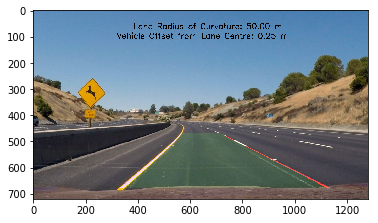

In [86]:
def annotate_lane_output(image, lanes_image, pos, roc, returndebug=False):
    # Unwarp the lane lines and region back to the original perspective and overlay on the original image
    pickle_warp_persp_data = pickle.load(open('./camera_cal/warp_persp_data.p', 'rb'))
    Minv = pickle_warp_persp_data['Minv']
    unwarp_image = cv2.warpPerspective(lanes_image, Minv, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    line_removed_image = cv2.addWeighted(image, 1, unwarp_image, -0.5, 0)
    output = cv2.addWeighted(line_removed_image, 1, unwarp_image, 1, 0)
    # Annotate the top of the image with text info of the radius of curvature and vehicle offset from lane centre
    roc_text = "Lane Radius of Curvature: {0:.2f} m".format(roc)
    roc_loc = (int(0.3*image.shape[1]), int(0.1*image.shape[0]))
    pos_text = "Vehicle Offset from Lane Centre: {0:.2f} m".format(pos)
    pos_loc = (int(0.25*image.shape[1]), int(0.15*image.shape[0]))
    cv2.putText(output, roc_text , roc_loc, cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2)
    cv2.putText(output, pos_text, pos_loc, cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2)
    if returndebug==False:
        return output
    else:
        return lanes_image

# Test it on a sample image
ltracker = lane_lines_tracker()
sample_img = mpimg.imread('./test_images/test2.jpg')
detectlanepixels_img1, left_coeffs, right_coeffs = fit_lane_pixels(warp_birdseyeview(combined_thresh(camera_undistort(sample_img))), ltracker, returndebug=False)
lanes_image = plot_lanes(detectlanepixels_img1, left_coeffs, right_coeffs)[0]
plt.imshow(annotate_lane_output(sample_img, lanes_image, 0.250000, 50.00000, returndebug=False))
ltracker.reset()

### Combined Pipeline Function ###
All the above functions need to be called in their order, so that the images can be fed in to get annoted images as an output through one simple function.

In [87]:
def process_image(image):
    # Remove distortion effects caused by camera
    undist_image = camera_undistort(image)
    # Use thresholding to capture mainly the lane lines
    thresh_image = combined_thresh(undist_image)
    # Transform the image with lane lines captured into a bird's eye view using perspective transform
    birdseyeview_image = warp_birdseyeview(thresh_image)
    # Find the pixels corresponding to the lane lines and fit them into 2 second order curves
    detectlanepixels_image, left_coeffs, right_coeffs = fit_lane_pixels(birdseyeview_image, ltracker, returndebug=False)
    # Plot the curves to represent the lane lines
    lanes_image, y_curve, left_x_curve, right_x_curve = plot_lanes(detectlanepixels_image, left_coeffs, right_coeffs)
    # Calculate radius of curvature of the lane and position of the vehicle with respect to the lane centre 
    pos, roc = calc_pos_curvature(y_curve, left_x_curve, right_x_curve, image.shape[1], image.shape[0])
    # Annotate the image with the lane lines, the lane area and also the position and curvature information
    result = annotate_lane_output(image, lanes_image, pos, roc, returndebug=False)
    return result

## 3. Pipeline applied on Test Images ##

In [88]:
ltracker = lane_lines_tracker()
for test_img_file in glob.glob('./test_images/*.jpg'):
    test_img = mpimg.imread(test_img_file)
    result_img = process_image(test_img)
    output_img = cv2.cvtColor(result_img, cv2.COLOR_RGB2BGR)
    cv2.imwrite('./output_images/output_' + os.path.basename(test_img_file), output_img)
    ltracker.reset()

## 4. Pipeline applied on Project Video ##

In [75]:
ltracker = lane_lines_tracker()
project_video_output = './output_videos/output_project_video.mp4'
clip1 = VideoFileClip('./project_video.mp4')
project_clip = clip1.fl_image(process_image)
%time project_clip.write_videofile(project_video_output, audio=False)
ltracker.reset()

[MoviePy] >>>> Building video ./output_videos/output_project_video.mp4
[MoviePy] Writing video ./output_videos/output_project_video.mp4


100%|█████████▉| 1260/1261 [03:38<00:00,  5.72it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/output_project_video.mp4 

CPU times: user 5min 26s, sys: 13.6 s, total: 5min 40s
Wall time: 3min 40s


In [76]:
HTML("""
<video width="960" height="540" controls>
    <source src="{0}">
</video>
""".format(project_video_output))

## 5. Pipeline applied on Challenge Videos ##

The output of the pipline applied to the first challenge video is shown below:

In [77]:
ltracker = lane_lines_tracker()
challenge1_video_output = './output_videos/output_challenge1_video.mp4'
clip2 = VideoFileClip('./challenge_video.mp4')
challenge1_clip = clip2.fl_image(process_image)
%time challenge1_clip.write_videofile(challenge1_video_output, audio=False)
ltracker.reset()

[MoviePy] >>>> Building video ./output_videos/output_challenge1_video.mp4
[MoviePy] Writing video ./output_videos/output_challenge1_video.mp4


100%|██████████| 485/485 [01:19<00:00,  5.98it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/output_challenge1_video.mp4 

CPU times: user 2min 2s, sys: 5.16 s, total: 2min 7s
Wall time: 1min 21s


In [78]:
HTML("""
<video width="960" height="540" controls>
    <source src="{0}">
</video>
""".format(challenge1_video_output))

The output of the pipline applied to the second (harder) challenge video is shown below:

In [79]:
ltracker = lane_lines_tracker()
challenge2_video_output = './output_videos/output_harder_challenge_video.mp4'
clip3 = VideoFileClip('./harder_challenge_video.mp4')
challenge2_clip = clip3.fl_image(process_image)
%time challenge2_clip.write_videofile(challenge2_video_output, audio=False)
ltracker.reset()

[MoviePy] >>>> Building video ./output_videos/output_harder_challenge_video.mp4
[MoviePy] Writing video ./output_videos/output_harder_challenge_video.mp4


100%|█████████▉| 1199/1200 [04:01<00:00,  5.37it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/output_harder_challenge_video.mp4 

CPU times: user 5min 43s, sys: 15.8 s, total: 5min 59s
Wall time: 4min 3s


In [80]:
HTML("""
<video width="960" height="540" controls>
    <source src="{0}">
</video>
""".format(challenge2_video_output))